In [1]:
#import all relevant packages
import torch, torchvision
import torchvision.transforms as transforms
import numpy as np
from backpack import backpack, extend
from backpack.extensions import DiagHessian
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
from torch.nn import functional as F

s=10
np.random.seed(s)
torch.manual_seed(s)
torch.cuda.manual_seed(s)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Data wrangling

In [2]:
# data wrangling: load MNIST
MNIST_transform = transforms.Compose([
    transforms.ToTensor(),
])


MNIST_train = torchvision.datasets.MNIST(
        '~/data/mnist',
        train=True,
        download=True,
        transform=MNIST_transform)


MNIST_test = torchvision.datasets.MNIST(
        '~/data/mnist',
        train=False,
        download=False,
        transform=MNIST_transform)


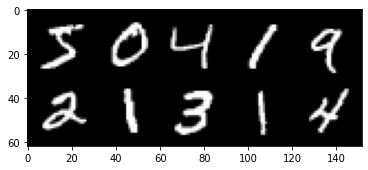

In [3]:
# have a look at the data to verify
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.imshow(npimg)
    plt.show()

images = MNIST_train.data[:10].view(10, 1, 28, 28)
imshow(torchvision.utils.make_grid(images, nrow=5))


In [4]:
mnist_train_loader = torch.utils.data.dataloader.DataLoader(
    MNIST_train,
    batch_size=128,
    shuffle=True
)

mnist_test_loader = torch.utils.data.dataloader.DataLoader(
    MNIST_test,
    batch_size=128,
    shuffle=False,
)


# Training routine

In [5]:
#set up the network
def NN(num_classes=10):
    
    features = torch.nn.Sequential(
        torch.nn.Conv2d(1, 32, 5),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,2),
        torch.nn.Conv2d(32, 32, 5),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,2),
        torch.nn.Flatten(),
        torch.nn.Linear(4 * 4 * 32, num_classes)
    )
    return(features)


In [6]:
#set up the training routine
mnist_model = NN(num_classes=10)
loss_function = torch.nn.CrossEntropyLoss()

mnist_train_optimizer = torch.optim.Adam(mnist_model.parameters(), lr=1e-3, weight_decay=5e-4)
#dont use SGD, it is way worse than Adam here
MNIST_PATH = "MNIST_weights_seed={}.pth".format(s)
#print(MNIST_PATH)

In [7]:
# helper function to get accuracy
def get_accuracy(output, targets):
    """Helper function to print the accuracy"""
    predictions = output.argmax(dim=1, keepdim=True).view_as(targets)
    return predictions.eq(targets).float().mean().item()


In [8]:
# Write the training routine and save the model at FMNIST_PATH

def train(verbose=False, num_iter=5):
    max_len = len(mnist_train_loader)
    for iter in range(num_iter):
        for batch_idx, (x, y) in enumerate(mnist_train_loader):
            output = mnist_model(x)

            accuracy = get_accuracy(output, y)

            loss = loss_function(output, y)
            loss.backward()
            mnist_train_optimizer.step()
            mnist_train_optimizer.zero_grad()

            if verbose:
                if batch_idx % 10 == 0:
                    print(
                        "Iteration {}; {}/{} \t".format(iter, batch_idx, max_len) +
                        "Minibatch Loss %.3f  " % (loss) +
                        "Accuracy %.0f" % (accuracy * 100) + "%"
                    )

    print("saving model at: {}".format(MNIST_PATH))
    torch.save(mnist_model.state_dict(), MNIST_PATH)

In [9]:
#after training it once, comment this out to save time if you rerun the entire script
#train(verbose=True, num_iter=5)


In [10]:
#predict in distribution
MNIST_PATH = "../trained_weights/MNIST/MNIST_weights_seed={}.pth".format(s)

mnist_model = NN(num_classes=10)
print("loading model from: {}".format(MNIST_PATH))
mnist_model.load_state_dict(torch.load(MNIST_PATH))
mnist_model.eval()

#acc = []

#max_len = len(mnist_test_loader)
#for batch_idx, (x, y) in enumerate(mnist_test_loader):
#        output = mnist_model(x)
#        accuracy = get_accuracy(output, y)
#        if batch_idx % 10 == 0:
#            print(
#                "Batch {}/{} \t".format(batch_idx, max_len) + 
#                "Accuracy %.0f" % (accuracy * 100) + "%"
#            )
#        acc.append(accuracy)
#    
#avg_acc = np.mean(acc)
#print('overall test accuracy on MNIST: {:.02f} %'.format(avg_acc * 100))

loading model from: ../trained_weights/MNIST/MNIST_weights_seed=10.pth


Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
  (7): Linear(in_features=512, out_features=10, bias=True)
)

# Laplace approximation of the weights
* we use the BackPACK package to approximate the Hessian of the parameters. Especially look at the DiagHessian() method.
* we do one iteration over the entire training set and use the mean of the Hessian of the mini-batches as the best approximation of the Hessian.
* we add a prior variance to our Hessian. The precision is 1 over the variance. we use a prior precision of 10, 20, and 50 (or variance of 1/10, 1/20, 1/50).
    * edit: I will use precicisions of 10, 60, 120, 1000 in the following


In [11]:
def get_Hessian_NN(model, train_loader, prec0, device='cpu', verbose=True):
    lossfunc = torch.nn.CrossEntropyLoss()

    extend(lossfunc, debug=False)
    extend(model, debug=False)

    Cov_diag = []
    for param in model.parameters():
        ps = param.size()
        print("parameter size: ", ps)
        Cov_diag.append(torch.zeros(ps, device=device))
        #print(param.numel())

    #var0 = 1/prec0
    max_len = len(train_loader)

    with backpack(DiagHessian()):

        for batch_idx, (x, y) in enumerate(train_loader):

            if device == 'cuda':
                x, y = x.float().cuda(), y.long().cuda()

            model.zero_grad()
            lossfunc(model(x), y).backward()

            with torch.no_grad():
                # Hessian of weight
                for idx, param in enumerate(model.parameters()):

                    H_ = param.diag_h
                    #add prior here
                    H_ += prec0 * torch.ones(H_.size())
                    H_inv = torch.sqrt(1/H_) #<-- standard deviation
                    #H_inv = 1/H_              #<-- variance 

                    rho = 1-1/(batch_idx+1)

                    Cov_diag[idx] = rho*Cov_diag[idx] + (1-rho)* H_inv
            
            if verbose:
                print("Batch: {}/{}".format(batch_idx, max_len))
    
    return(Cov_diag)

In [12]:
#MNIST_NN_Std_prec_1 = get_Hessian_NN(model=mnist_model, train_loader=mnist_train_loader, prec0=1,verbose=False)
#MNIST_NN_Std_prec_01 = get_Hessian_NN(model=mnist_model, train_loader=mnist_train_loader, prec0=0.1,verbose=False)
#MNIST_NN_Std_prec_001 = get_Hessian_NN(model=mnist_model, train_loader=mnist_train_loader, prec0=0.01,verbose=False)
#MNIST_NN_Std_prec_0001 = get_Hessian_NN(model=mnist_model, train_loader=mnist_train_loader, prec0=0.001,verbose=False)
#MNIST_NN_Std_prec_00001 = get_Hessian_NN(model=mnist_model, train_loader=mnist_train_loader, prec0=0.0001,verbose=False)
#MNIST_NN_Std_prec_000001 = get_Hessian_NN(model=mnist_model, train_loader=mnist_train_loader, prec0=0.00001,verbose=False)
#torch.save(MNIST_NN_Std_prec_1, 'Hessian_prec1_seed1.pth')
#torch.save(MNIST_NN_Std_prec_01, 'Hessian_prec01_seed1.pth')
#torch.save(MNIST_NN_Std_prec_001, 'Hessian_prec001_seed1.pth')
#torch.save(MNIST_NN_Std_prec_0001, 'Hessian_prec0001_seed1.pth')
#torch.save(MNIST_NN_Std_prec_00001, 'Hessian_prec00001_seed1.pth')
#torch.save(MNIST_NN_Std_prec_000001, 'Hessian_prec000001_seed1.pth')

In [13]:
MNIST_NN_Std_prec_1 = torch.load('Hessians/MNIST/Hessian_prec1_seed{}.pth'.format(s))
MNIST_NN_Std_prec_01 = torch.load('Hessians/MNIST/Hessian_prec01_seed{}.pth'.format(s))
MNIST_NN_Std_prec_001 = torch.load('Hessians/MNIST/Hessian_prec001_seed{}.pth'.format(s))
MNIST_NN_Std_prec_0001 = torch.load('Hessians/MNIST/Hessian_prec0001_seed{}.pth'.format(s))
MNIST_NN_Std_prec_00001 = torch.load('Hessians/MNIST/Hessian_prec00001_seed{}.pth'.format(s))
MNIST_NN_Std_prec_000001 = torch.load('Hessians/MNIST/Hessian_prec000001_seed{}.pth'.format(s))

## As you can see, the variance gets smaller, the higher the precision gets

## Now we want to look at the single layers of our network, and how they behave w.r.t. the variance
* every tensor represents one of the six layers of out network


## visualize the first layer of our networks in a heatmap
* therefore we put the tensor in the right form/dimensions, by concatening all of its included arrays and then reshaping the tensor


In [14]:
"""
import seaborn as sns
def visualize(tensor):
    output = tensor[0][0]
    for i in range(1, len(tensor[0])):
        output = np.concatenate((output, tensor[0][i]))
    output = output.transpose(2, 0, 1).reshape(5, -1)
    heatmap = sns.heatmap(output)
    plt.xticks = (np.arange(0, step=20))
    plt.show()
"""   

'\nimport seaborn as sns\ndef visualize(tensor):\n    output = tensor[0][0]\n    for i in range(1, len(tensor[0])):\n        output = np.concatenate((output, tensor[0][i]))\n    output = output.transpose(2, 0, 1).reshape(5, -1)\n    heatmap = sns.heatmap(output)\n    plt.xticks = (np.arange(0, step=20))\n    plt.show()\n'

In [15]:
#visualize(MNIST_NN_Hessian_diag_10)

In [16]:
def meancalc(Hessian_diag_x):
    i = 0 
    vals = []
    for name, parameter in mnist_model.named_parameters():
        mean = torch.mean(Hessian_diag_x[i])
        #print("mean standard deviation of layer {0:s}: {1:.4f}".format(name, mean.item()))
        #print(mean.item(), end =", ")
        vals.append(mean.item())
        i += 1
    return vals


In [17]:
walla = meancalc(MNIST_NN_Std_prec_000001)

In [18]:
meancalc(Hessian_diag_x=MNIST_NN_Std_prec_000001)

[34.59629440307617,
 16.765005111694336,
 106.05382537841797,
 65.05758666992188,
 58.86921310424805,
 26.483108520507812]

In [60]:
#
#mnist_number = 0
#linear_layer_index = 4 #linear layer has index 4
#linear_layer = MNIST_NN_Std_prec_00001[linear_layer_index][mnist_number]

#reshape the flattened array to 32* (4x4)
#layer_split = np.array_split(np.array(linear_layer), 32)
#for i in range(len(layer_split)-1):
#    layer_split[i] = np.reshape(layer_split[i], (4, -1))

#plot setup
#fig, axs = plt.subplots(4,8, figsize=(20, 15))
#fig.subplots_adjust(hspace = .001, wspace=.001)
#axs = axs.ravel()

#iterate through the features and plot them
#for i in range(len(layer_split)):
#    layer_split[i] = np.reshape(layer_split[i], (4, -1))
#    axs[i].imshow(layer_split[i])
#    axs[i].set_title('feature '+str(i+1))



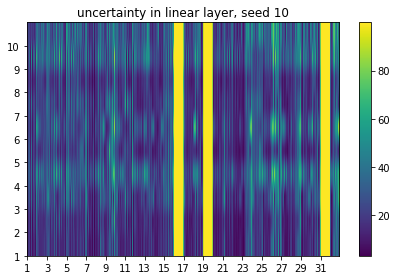

In [20]:
plt.imshow(MNIST_NN_Std_prec_00001[4], extent=[0,512,0,1],  aspect='auto')
ax = plt.gca()
ax.set_xticks(np.arange(1, 512, 32));
ax.set_xticklabels(np.arange(1, 32, 2));
ax.set_yticks(np.arange(0, 1, 0.1));
ax.set_yticklabels(np.arange(1,11,1));
ax.set_title('uncertainty in linear layer, seed {}'.format(s))
plt.colorbar()
plt.tight_layout()
plt.show()
#plt.savefig('linear_seed1000={}'.format(s))

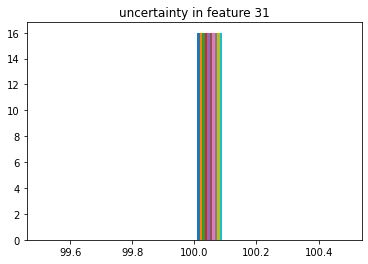

In [22]:
def linear_hist_feature_uncertainty(feature):
    to_hist_uncertainty = []
    target_feature = feature
    for i in range(10):
        uncertainty = MNIST_NN_Std_prec_00001[4][i].detach().numpy()
        uncertainty = np.array_split(np.array(uncertainty), 32)
        to_hist_uncertainty.append(uncertainty[target_feature -1])
    plt.hist(to_hist_uncertainty)
    plt.title('uncertainty in feature {}'.format(target_feature))
    
linear_hist_feature_uncertainty(31)

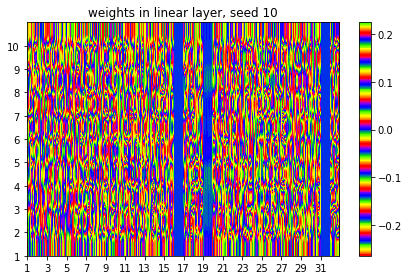

In [23]:
for name, parameters in mnist_model.named_parameters():
    if name == '7.weight':
        params = parameters

params_arr = params.detach().numpy()

plt.imshow(params_arr, cmap='prism',extent=[0,512,0,1],  aspect='auto')
ax = plt.gca()
ax.set_xticks(np.arange(1, 512, 32));
ax.set_xticklabels(np.arange(1, 32, 2));
ax.set_yticks(np.arange(0, 1, 0.1));
ax.set_yticklabels(np.arange(1,11,1));
ax.set_title('weights in linear layer, seed {}'.format(s))
plt.colorbar()
plt.tight_layout()
im = plt.show()
#plt.hist(params_arr)

In [24]:
def hist_feature(feature):
    to_hist = []
    target_feature = feature
    for i in range(10):
        weights = params[i].detach().numpy()
        weights = np.array_split(np.array(weights), 32)
        to_hist.append(weights[target_feature -1])
    plt.hist(to_hist)
    plt.title('weights in feature {}'.format(target_feature))

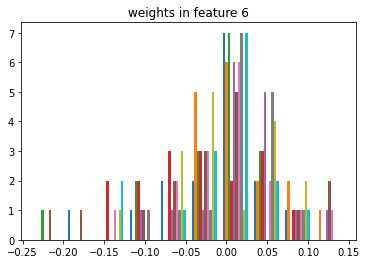

In [25]:
hist_feature(6)

In [26]:
print(MNIST_NN_Std_prec_00001[3][3])
print(MNIST_NN_Std_prec_00001[3][10])


tensor(53.4046)
tensor(29.9483)


In [27]:
#for name, parameters in mnist_model.named_parameters():
 #   if name == '3.weight':
  #      params = parameters

#params_arr = params.detach().numpy()




In [28]:
print(MNIST_NN_Std_prec_00001[2][31][31])
print(MNIST_NN_Std_prec_00001[2].size())

tensor([[88.1208, 72.8930, 58.6302, 65.2774, 71.0039],
        [82.7461, 62.4221, 59.7587, 72.0151, 63.4837],
        [67.5186, 52.5282, 61.2310, 71.6648, 56.2232],
        [56.6846, 50.6730, 62.3737, 64.2471, 56.2172],
        [53.5680, 53.2901, 58.7345, 56.7372, 59.9895]])
torch.Size([32, 32, 5, 5])


# visualize the second conv layer kernels


### first visualize the uncertaintys of the kernels

In [29]:
#fig, axs = plt.subplots(4,8, figsize=(20, 15))
#fig.subplots_adjust(hspace = .001, wspace=.001)
#axs = axs.ravel()

#for i in range(32):
    #for j in range(32):
 #   axs[i].imshow(MNIST_NN_Std_prec_0001[2][i][3])

29


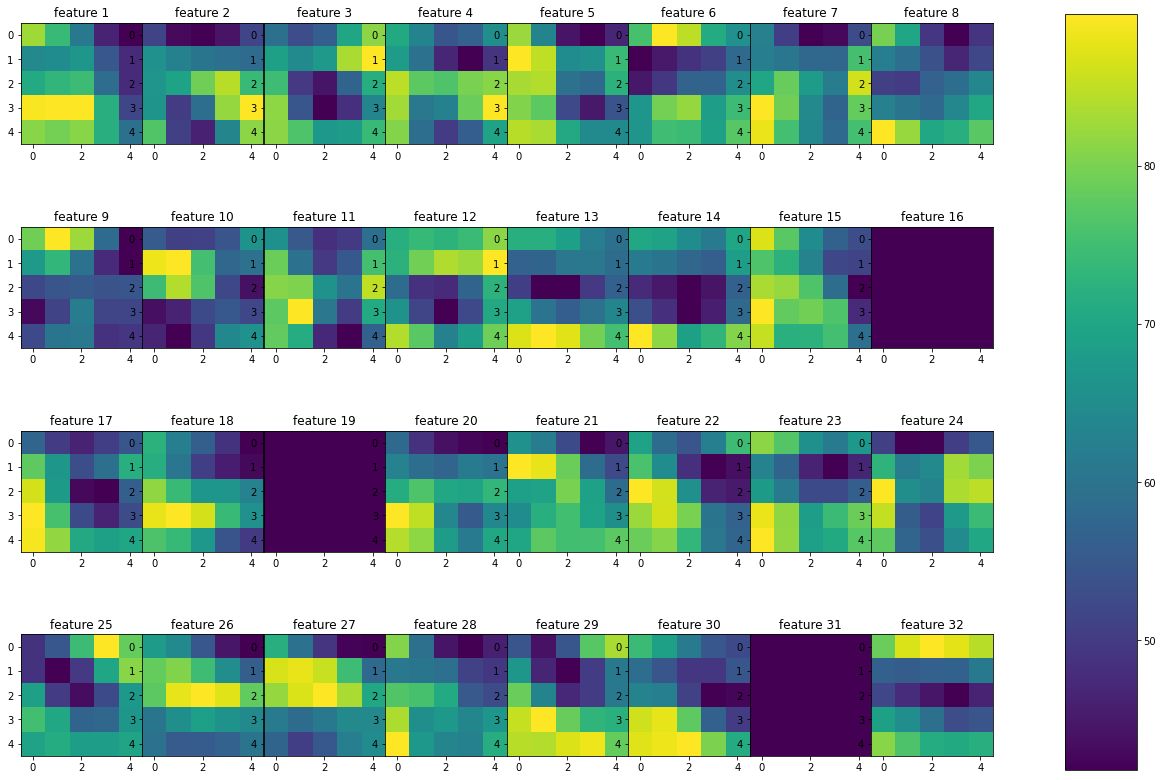

In [80]:
from random import randint

#choose a random between 0 and 31 for 2nd dimension
j = randint(0, 31)

fig, axs = plt.subplots(4,8, figsize=(20, 15))
fig.subplots_adjust(hspace = .001, wspace=.001)
#axs = axs.ravel()
print(j)
#for i in range(32):
for i, ax in enumerate(axs.flat):
    
    #for j in range(32):
    im = ax.imshow(MNIST_NN_Std_prec_00001[2][i][j])
    ax.set_title('feature '+str(i+1))
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

#interesting: s2 j24 j7

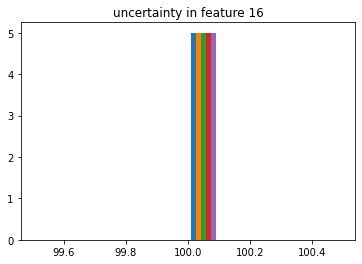

In [31]:
def hist_feature_uncertainty(feature, j):
    to_hist_uncertainty = []
    target_feature = feature
    uncertainty = MNIST_NN_Std_prec_00001[2][target_feature -1][j].detach().numpy()
    plt.hist(uncertainty)
    plt.title('uncertainty in feature {}'.format(target_feature))
    
hist_feature_uncertainty(16, 3)

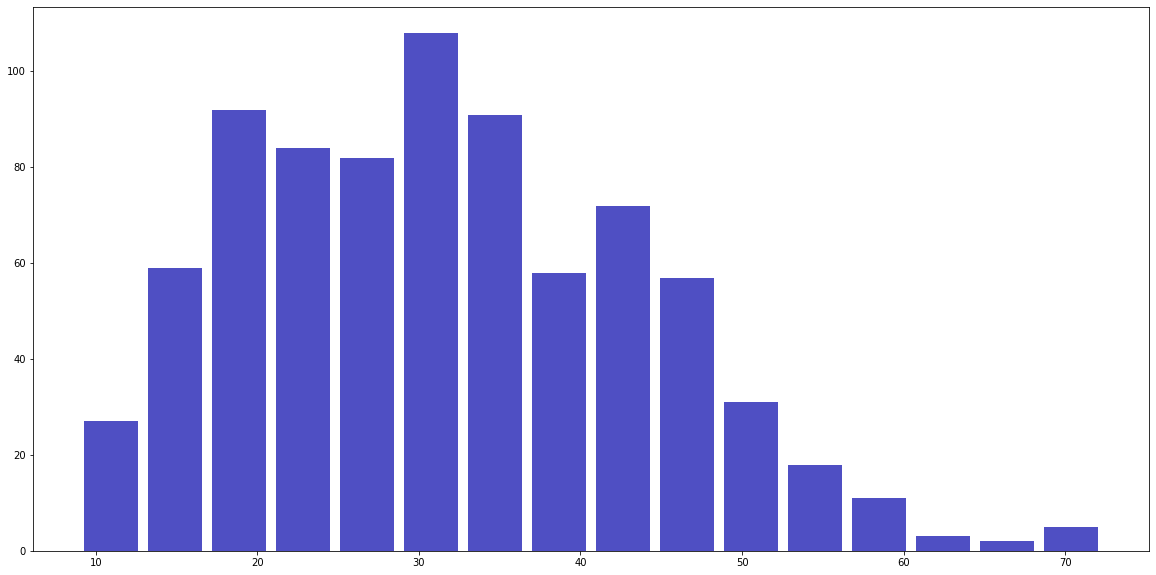

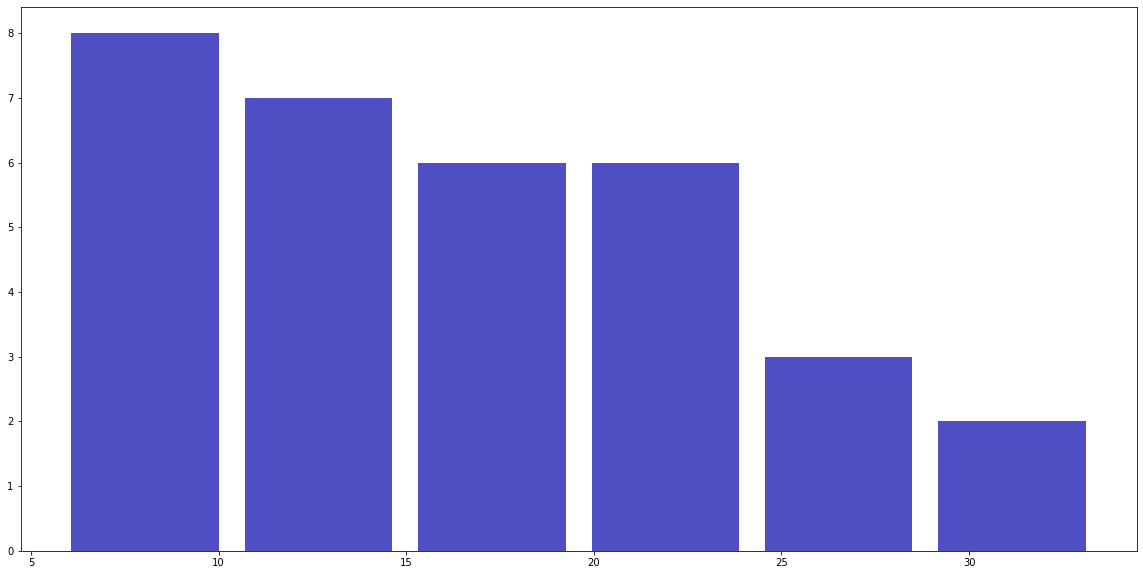

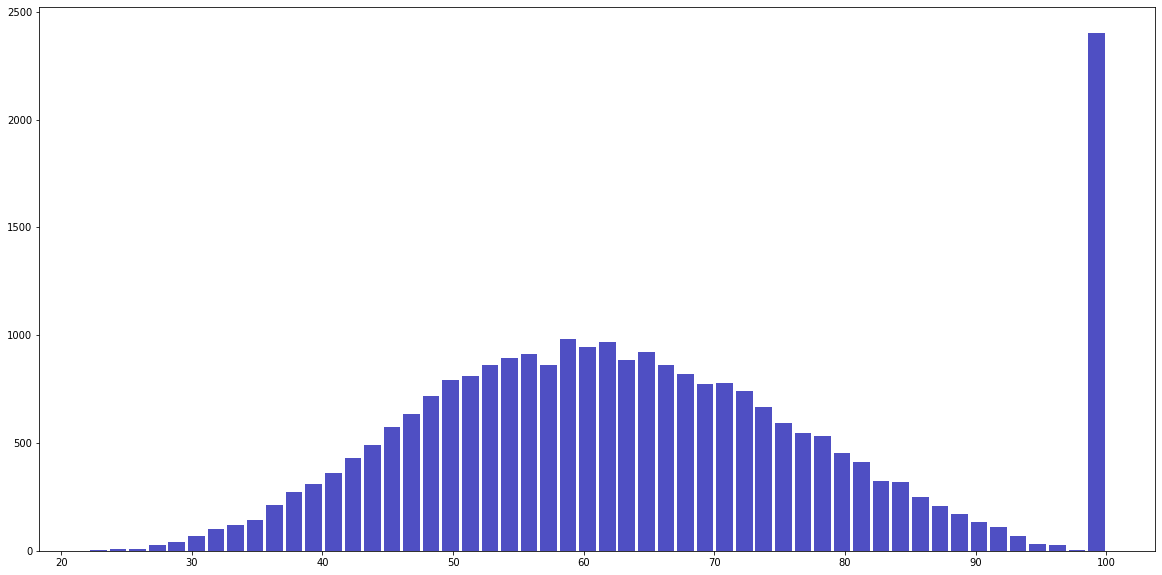

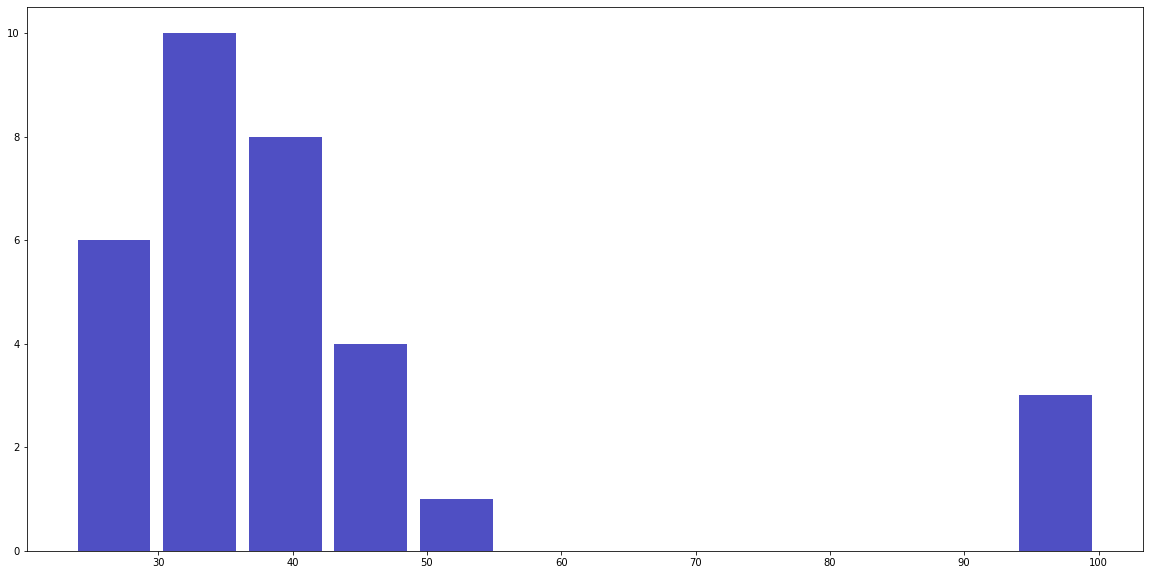

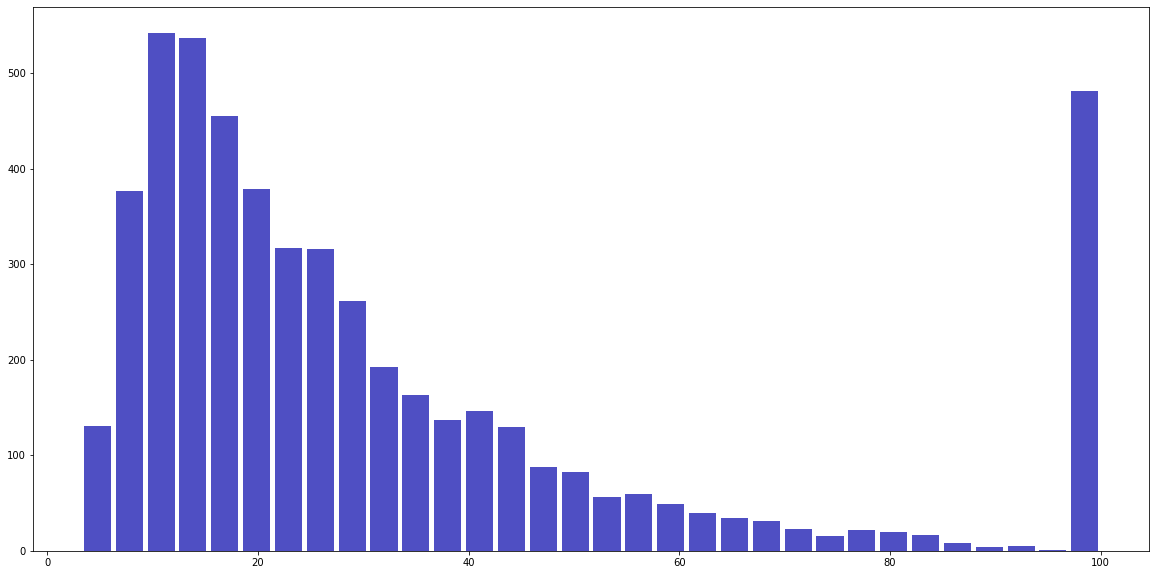

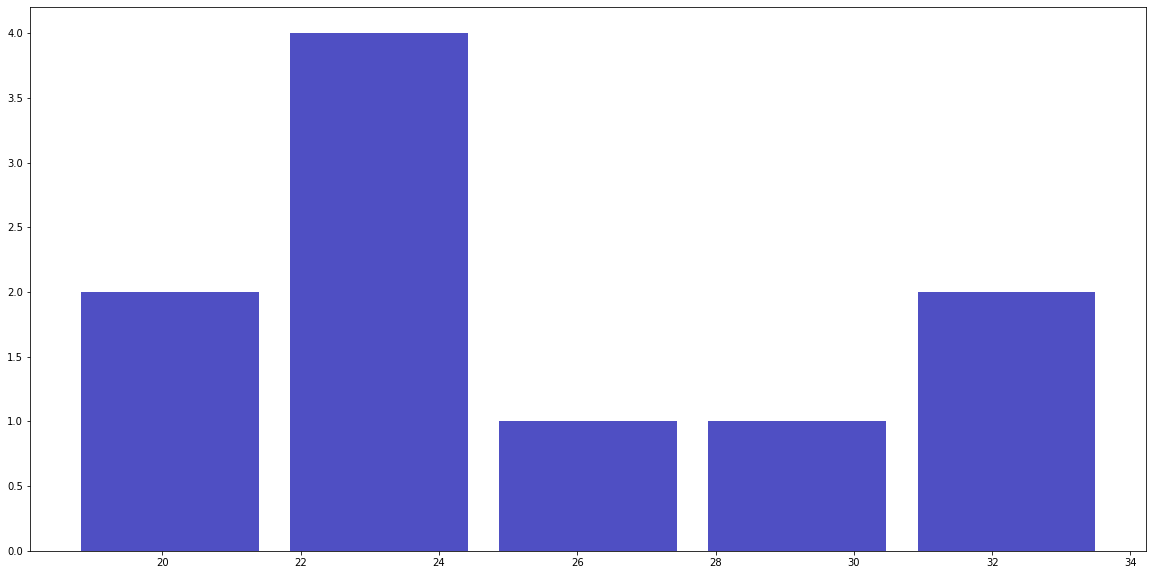

In [93]:
for i in range(6):
    plt.hist(torch.flatten(MNIST_NN_Std_prec_00001[i]), bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
    plt.show()

### in kernels with high uncertainty the biases are maximal (100 for precision 0.0001)

In [33]:
print(MNIST_NN_Std_prec_00001[3])

tensor([ 38.5422,  48.7986,  39.2145,  53.4046,  44.4568,  33.7939,  25.7750,
         40.9449,  38.3119,  42.2931,  29.9483,  29.6199,  39.4759,  23.5201,
         36.2506, 100.0000,  31.9488,  40.6241, 100.0000,  32.2677,  43.8007,
         32.8772,  31.9120,  33.1254,  36.1010,  34.3813,  28.4343,  28.7248,
         43.9191,  41.6926, 100.0000,  24.6157])


## Now viualize the weights of the kernels in the second conv layer (3.weight)

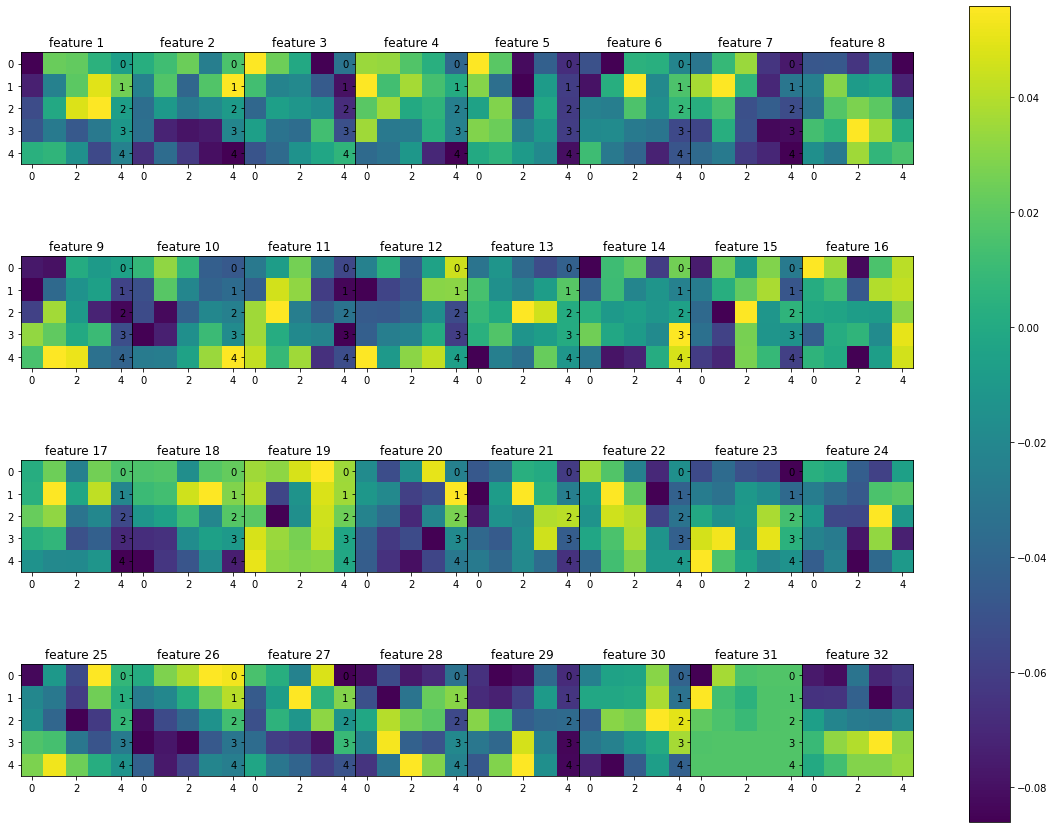

In [68]:
for name, parameters in mnist_model.named_parameters():
    if name == '3.weight':
        params = parameters

params_arr = params.detach().numpy()
#print(params_arr[31][2])
fig, axs = plt.subplots(4,8, figsize=(20, 15))
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()
#choose random number between 0 and 31 for 2nd dimension
j = randint(0, 31)
#print(j)
for i in range(32):
    #for j in range(32):
    im = axs[i].imshow(params_arr[i][11])
    axs[i].set_title('feature '+str(i+1))
cbar = fig.colorbar(im, ax=axs.ravel().tolist())



(array([1.8000e+01, 1.7100e+02, 1.2890e+03, 5.5210e+03, 1.1815e+04,
        5.3230e+03, 1.1800e+03, 2.3600e+02, 4.1000e+01, 6.0000e+00]),
 array([-0.20526604, -0.16024393, -0.11522181, -0.07019969, -0.02517757,
         0.01984455,  0.06486666,  0.10988878,  0.1549109 ,  0.19993302,
         0.24495514], dtype=float32),
 <a list of 10 Patch objects>)

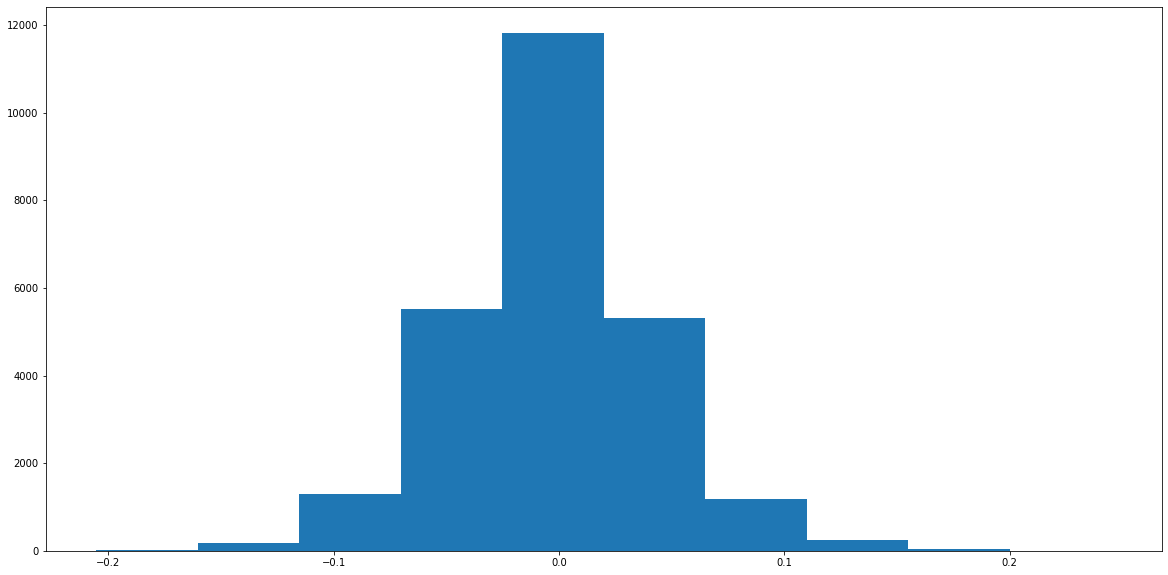

In [69]:
plt.hist(torch.flatten(params).detach().numpy())

In [36]:
weights_mean = np.zeros(32)
for j in range(32):
    for i in range(32):
        weights_mean[i] += torch.mean(params[i][j]).item()

for i in range(32):
    print('feature {0:}: {1:.10f}'.format((i+1), weights_mean[i]))
    


feature 1: 0.0059666452
feature 2: -0.0089833386
feature 3: -0.0579002402
feature 4: -0.0700454180
feature 5: -0.0188696263
feature 6: -0.2711225563
feature 7: -0.1514195080
feature 8: -0.0227418206
feature 9: -0.3265753373
feature 10: -0.0591045451
feature 11: -0.2620813646
feature 12: -0.0024020672
feature 13: -0.0327311282
feature 14: -0.0629170678
feature 15: -0.0241595024
feature 16: -0.0006202507
feature 17: -0.1014840602
feature 18: -0.0783754623
feature 19: -0.0006139267
feature 20: 0.0309179685
feature 21: -0.0255944100
feature 22: -0.0473270192
feature 23: -0.2021607981
feature 24: -0.1570561732
feature 25: -0.0603425263
feature 26: -0.2501169460
feature 27: -0.0348319189
feature 28: -0.0018854926
feature 29: -0.0217895254
feature 30: -0.0735128084
feature 31: -0.0000147107
feature 32: -0.2862234762


### look at the biases of the 3rd layer (3.bias)

In [37]:
for name, parameters in mnist_model.named_parameters():
    if name == '3.bias':
        params = parameters

params_arr = params.detach().numpy()
print(params_arr)
#plt.hist(params_arr)

[-1.44900875e-02 -9.10894573e-03 -9.83587932e-03 -7.89798272e-04
 -7.21850153e-03  2.08691861e-02  2.88660862e-02 -4.25469503e-02
 -1.67524032e-02  1.21499244e-02  1.29446089e-02  3.41820568e-02
 -3.60886604e-02 -2.31182240e-02 -2.60839686e-02 -3.03547102e-04
 -1.34819262e-02  6.91307127e-04 -7.95737014e-06 -3.87951955e-02
 -4.53119688e-02  1.88507121e-02  2.44233832e-02 -2.79734610e-04
 -1.64839849e-02  4.70759831e-02 -1.61317103e-02 -6.95558498e-03
 -1.62068959e-02 -1.13411257e-02 -2.17829962e-04 -5.74021973e-03]


## visualize the first conv layers kernels

### first visualize the uncertaintys of the kernels

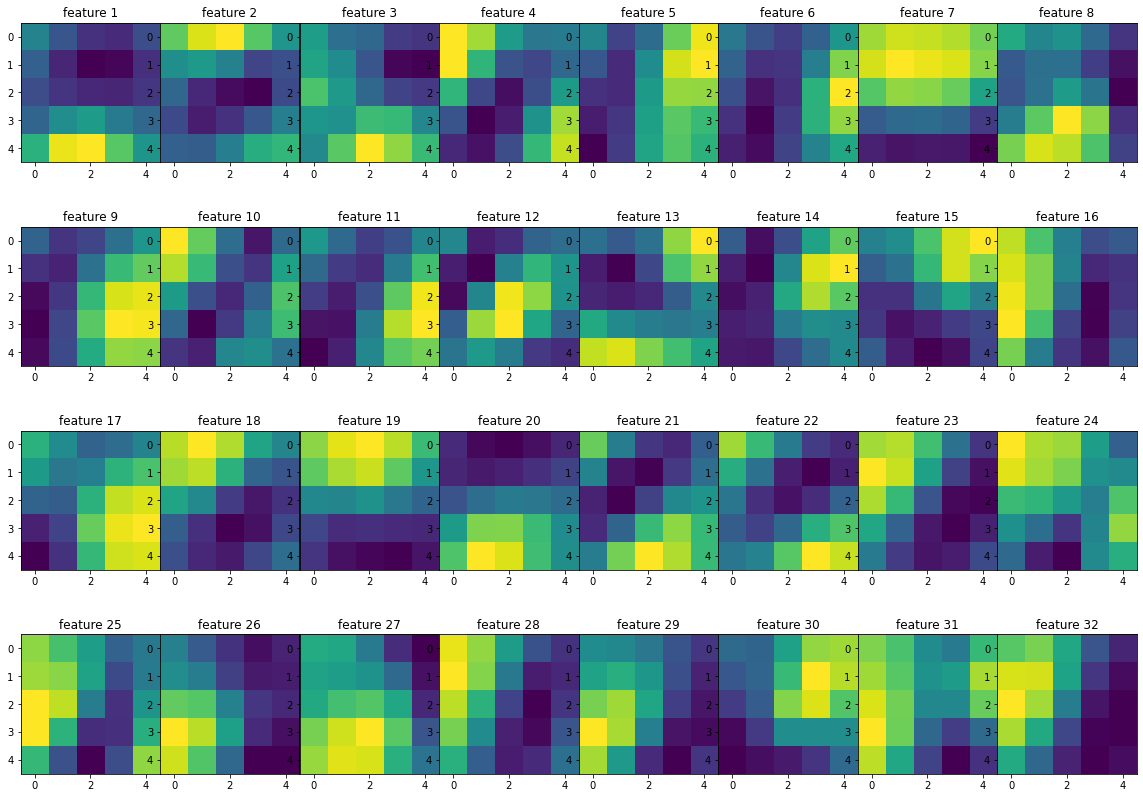

In [38]:
fig, axs = plt.subplots(4,8, figsize=(20, 15))
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()

for i in range(32):
    #for j in range(32):
    axs[i].imshow(MNIST_NN_Std_prec_0001[0][i][0])
    axs[i].set_title('feature '+str(i+1))

In [98]:
print(MNIST_NN_Std_prec_00001[1])

tensor([ 7.9270, 22.4338, 13.0170, 14.0585, 22.3860,  9.5844,  7.3245, 28.0332,
        13.9295, 21.9710, 15.1474, 17.4981, 16.9235, 16.6921,  7.7197, 15.0489,
        33.4594, 16.8674,  8.2249,  5.7305, 12.0845,  9.7315, 13.4196, 30.7977,
        26.0487, 19.9968, 20.8724, 13.3916, 24.4967, 13.4915, 22.2441,  6.4801])


## now visualize the weights of kernels in first conv layer

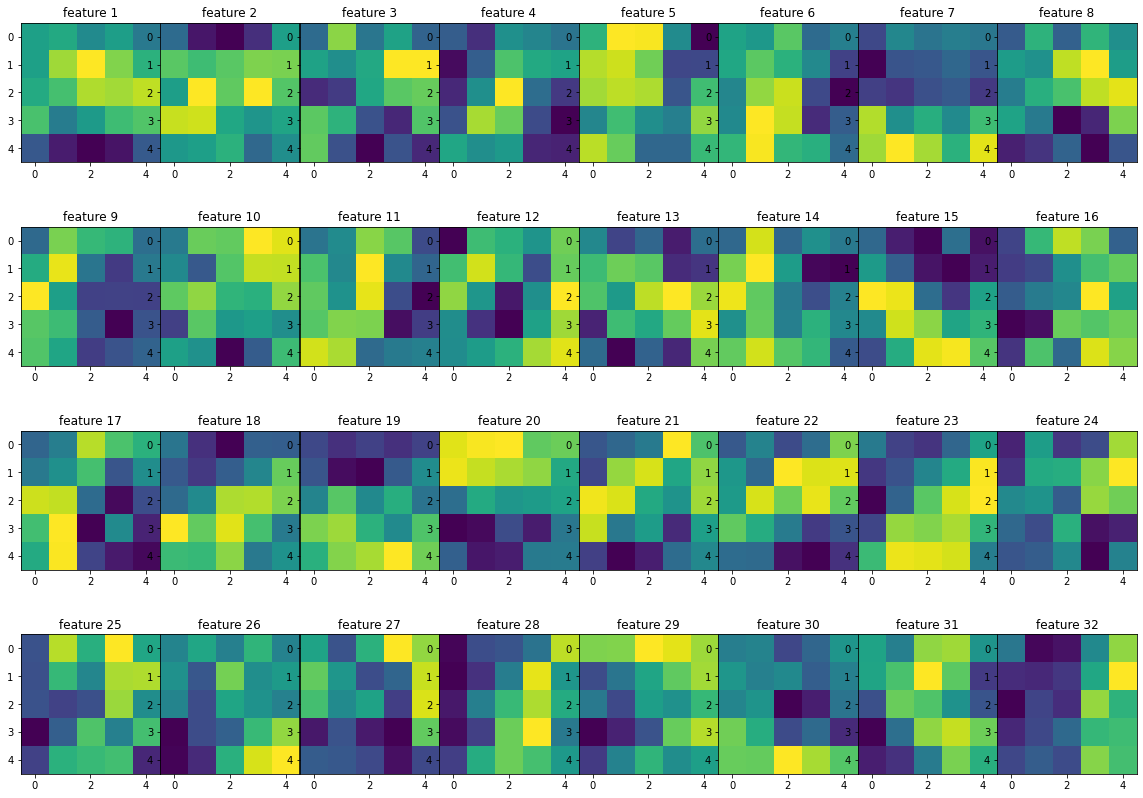

In [40]:
for name, parameters in mnist_model.named_parameters():
    if name == '0.weight':
        params = parameters

params_arr = params.detach().numpy()
#print(params_arr[31][2])
fig, axs = plt.subplots(4,8, figsize=(20, 15))
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()

for i in range(32):
    #for j in range(32):
    axs[i].imshow(params_arr[i][0])
    axs[i].set_title('feature '+str(i+1))

In [41]:
for name, parameters in mnist_model.named_parameters():
    if name == '0.bias':
        params = parameters

params_arr = params.detach().numpy()
print(params_arr)

[ 0.03747604 -0.0041063   0.01280332 -0.06438041 -0.02755804  0.0989439
  0.23182432  0.00267048 -0.02464941 -0.03449689 -0.00716485 -0.03366606
 -0.03798051 -0.01594592  0.07723489 -0.12925942 -0.03524789  0.00033315
  0.1764709   0.03270669  0.00061002  0.08961435 -0.10217491 -0.0182892
 -0.05772449 -0.07454024  0.00159894  0.08189826 -0.01846836 -0.00090082
 -0.05411324 -0.0392896 ]


## Is there a correlation between weight size and uncertainty in second conv layer?

In [42]:
#conv2_weights = mnist_model.named_parameters
for name, parameters in mnist_model.named_parameters():
    if name == '3.weight':
        conv2_weights = parameters#.detach().numpy()
        
conv2_uncertainties = MNIST_NN_Std_prec_00001[2]

#flatten the tensors
conv2_weights_flattened = torch.flatten(conv2_weights)
conv2_uncertainties_flattened = torch.flatten(conv2_uncertainties)

In [43]:
from scipy.stats import pearsonr

Pearsons correlation: -0.291


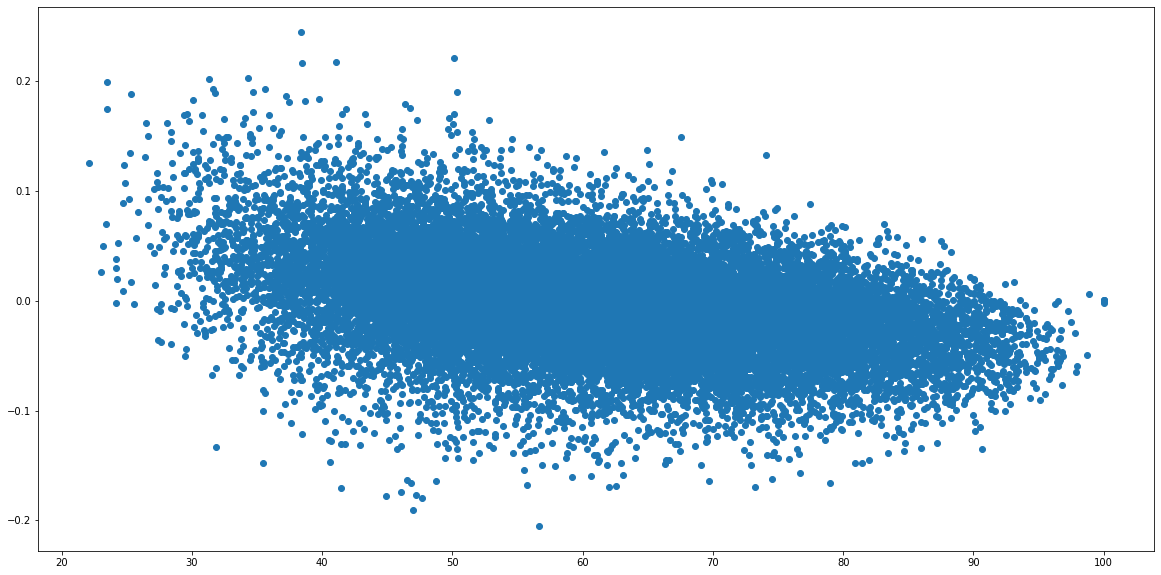

In [44]:
#plt.scatter(conv2_weights_flattened.detach().numpy(), conv2_uncertainties_flattened.detach().numpy())
plt.rcParams["figure.figsize"] = (20,10)
plt.scatter(conv2_uncertainties_flattened.detach().numpy(), conv2_weights_flattened.detach().numpy())
#print(np.cov(conv2_uncertainties_flattened.detach().numpy(), conv2_weights_flattened.detach().numpy()))
corr, _ = pearsonr(conv2_uncertainties_flattened.detach().numpy(), conv2_weights_flattened.detach().numpy())
print('Pearsons correlation: %.3f' % corr)

## comparison with linear layer

In [45]:
for name, parameters in mnist_model.named_parameters():
    if name == '7.weight':
        linear_weights = parameters
        
linear_uncertainties = MNIST_NN_Std_prec_00001[4]
linear_weights_flattened = torch.flatten(linear_weights)
linear_uncertainties_flattened = torch.flatten(linear_uncertainties)



Pearsons correlation: -0.118


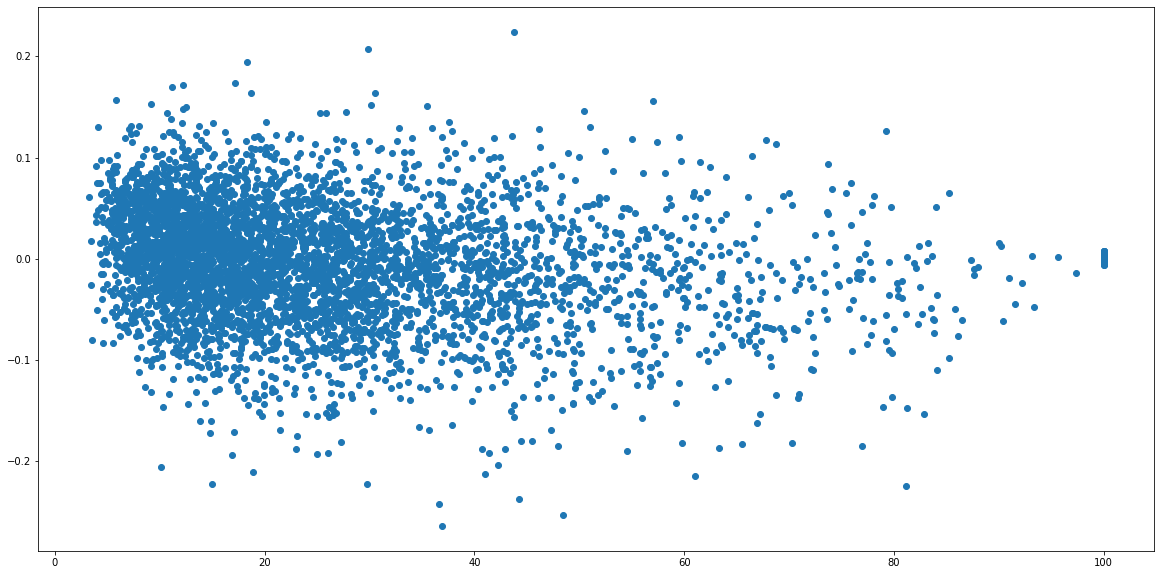

In [46]:

#plt.scatter(linear_weights_flattened.detach().numpy(), linear_uncertainties_flattened.detach().numpy())
plt.rcParams["figure.figsize"] = (20,10)
plt.scatter(linear_uncertainties_flattened.detach().numpy(), linear_weights_flattened.detach().numpy())
corr, _ = pearsonr(linear_uncertainties_flattened.detach().numpy(), linear_weights_flattened.detach().numpy())
print('Pearsons correlation: %.3f' % corr)

## also take a look at the first conv layer

In [47]:
for name, parameters in mnist_model.named_parameters():
    if name == '0.weight':
        conv1_weights = parameters
        
conv1_uncertainties = MNIST_NN_Std_prec_00001[0]
conv1_weights_flattened = torch.flatten(conv1_weights)
conv1_uncertainties_flattened = torch.flatten(conv1_uncertainties)



Pearsons correlation: -0.427


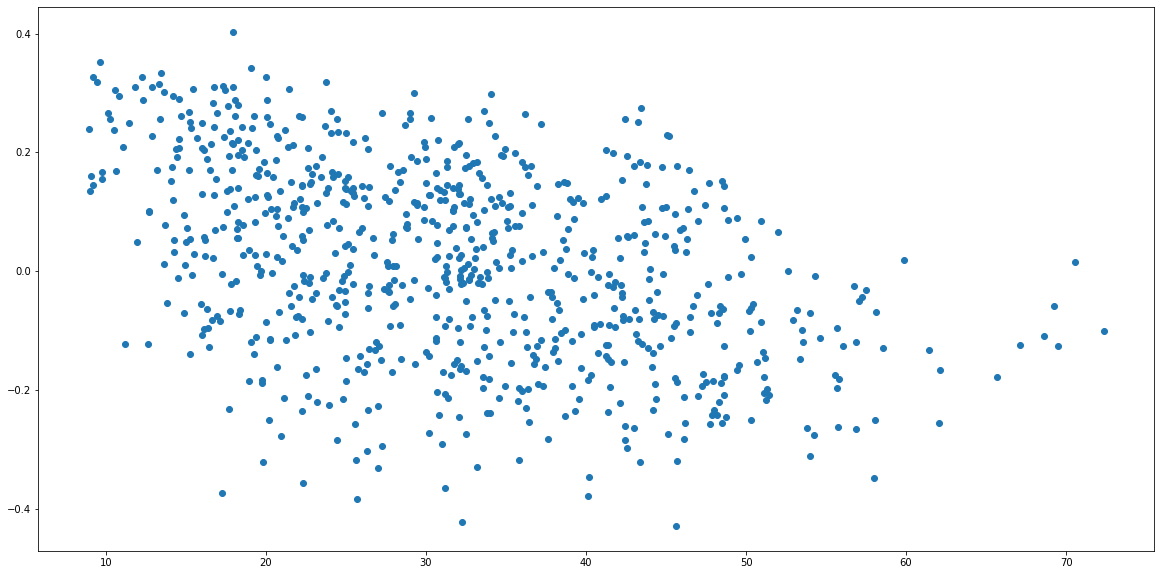

In [48]:
#plt.scatter(conv1_weights_flattened.detach().numpy(), conv1_uncertainties_flattened.detach().numpy())
#corr, _ = pearsonr(conv1_weights_flattened.detach().numpy(), conv1_uncertainties_flattened.detach().numpy())
plt.rcParams["figure.figsize"] = (20,10)
plt.scatter(conv1_uncertainties_flattened.detach().numpy(), conv1_weights_flattened.detach().numpy())
corr, _ = pearsonr(conv1_uncertainties_flattened.detach().numpy(), conv1_weights_flattened.detach().numpy())
print('Pearsons correlation: %.3f' % corr)

## scatterplot of weights and corresponding biases (meaningless, for now)

## first conv layer 

In [49]:
#weights
for name, parameters in mnist_model.named_parameters():
    if name == '0.weight':
        conv1_weights = parameters
        
for name, parameters in mnist_model.named_parameters():
    if name == '0.bias':
        conv1_biases = parameters
        
#reshape biases
conv1_biases = torch.reshape(conv1_biases, (1, 32))

Pearsons correlation: -0.633


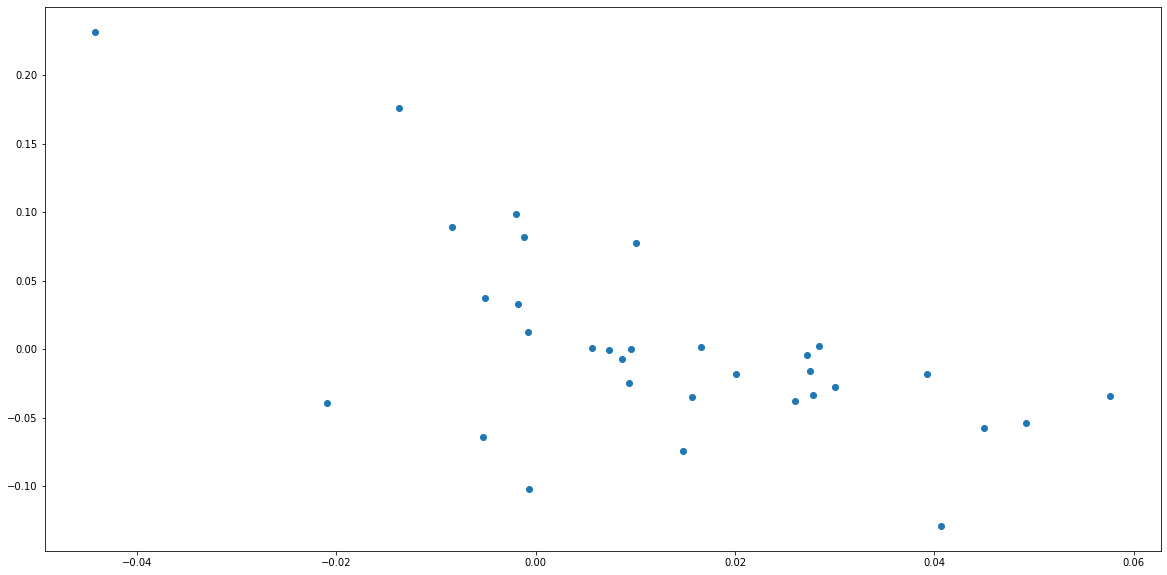

In [50]:
#flatten weights
#conv1_weights_flattened2 = torch.flatten(conv1_weights, start_dim=1)
#print(torch.mean(conv1_weights[31]))
avgs_conv1 = []
for i in range(0,32):
    avgs_conv1.append(torch.mean(conv1_weights[i]).item())
    
plt.scatter(avgs_conv1, conv1_biases.detach().numpy())
#plt.scatter(conv1_biases.detach().numpy(), avgs_conv1)
corr, _ = pearsonr(avgs_conv1, conv1_biases.detach().numpy()[0])
print('Pearsons correlation: %.3f' % corr)


## second conv layer

In [51]:
for name, parameters in mnist_model.named_parameters():
    if name == '3.weight':
        conv2_weights = parameters
        
for name, parameters in mnist_model.named_parameters():
    if name == '3.bias':
        conv2_biases = parameters
        
#reshape biases
#conv2_biases = torch.reshape(conv1_biases, (2, 32))

Pearsons correlation: -0.607


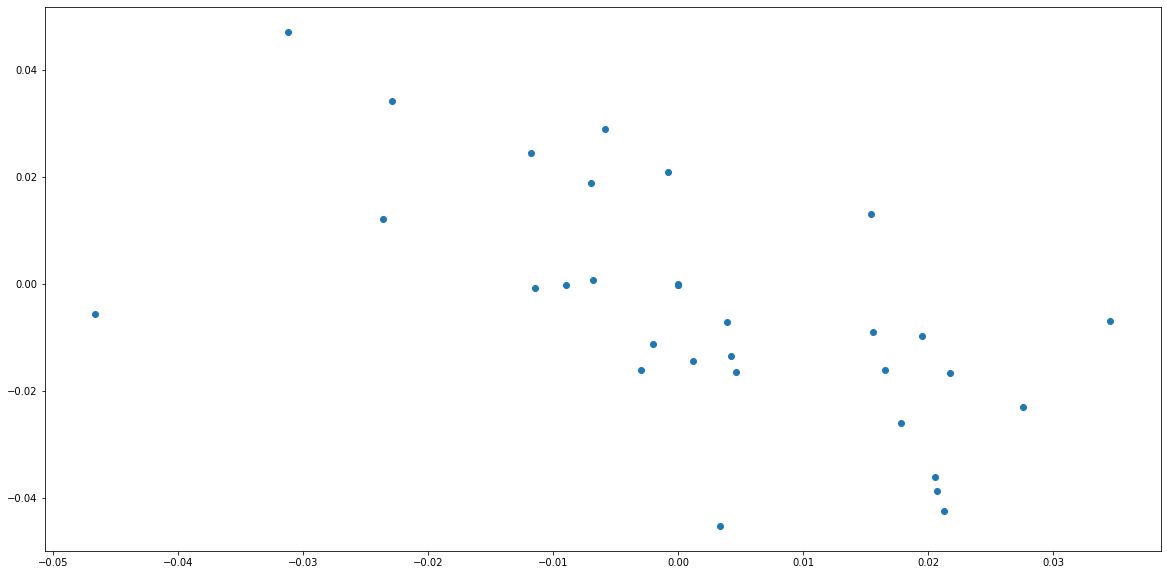

In [52]:
#print(conv2_weights[31][31])
def avg_flatten(j):
    avgs_conv2 = []
    for i in range(0, 32):
        avgs_conv2.append(torch.mean(conv2_weights[i][j]).item())
    return avgs_conv2
    
plt.scatter(avg_flatten(3), conv2_biases.detach().numpy())
#plt.scatter(conv2_biases.detach().numpy(), avg_flatten(3))
corr, _ = pearsonr(avg_flatten(3), conv2_biases.detach().numpy())
print('Pearsons correlation: %.3f' % corr)        

In [53]:
#for w in range(0, 32):
 #   plt.scatter(avg_flatten(w), conv2_biases.detach().numpy())

## linear layer

In [54]:
for name, parameters in mnist_model.named_parameters():
    if name == '7.weight':
        linear_weights = parameters
        
for name, parameters in mnist_model.named_parameters():
    if name == '7.bias':
        linear_biases = parameters

Pearsons correlation: 0.500


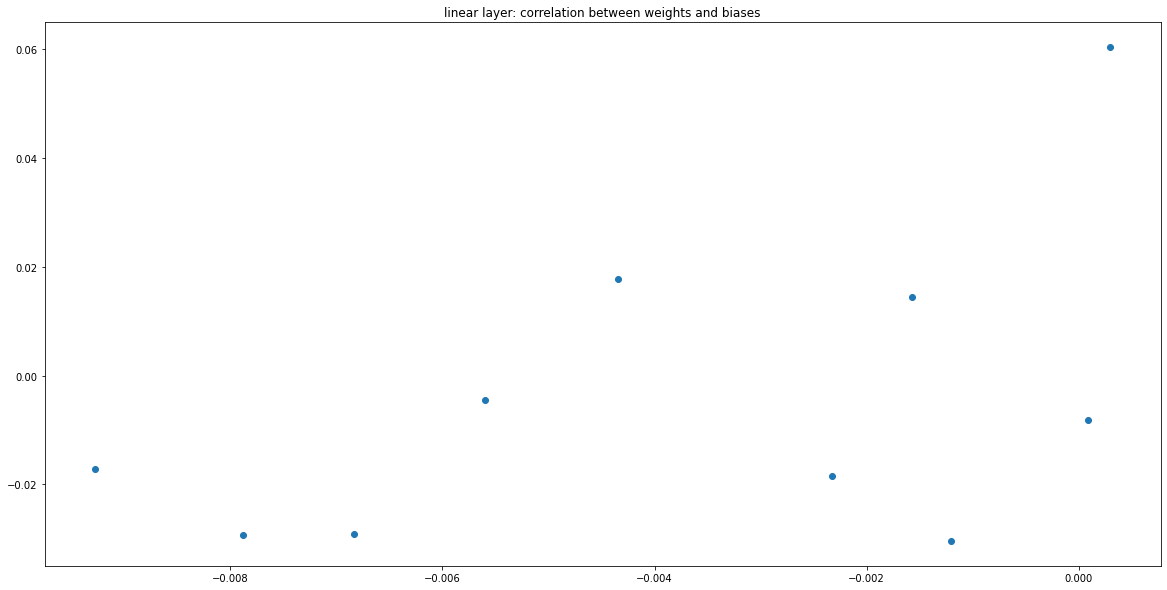

In [55]:
#print(linear_weights[1])
avgs_linear = []
for i in range(0, 10):
    avgs_linear.append(torch.mean(linear_weights[i]).item())
plt.scatter(avgs_linear, linear_biases.detach().numpy())
plt.title('linear layer: correlation between weights and biases')
corr, _ = pearsonr(avgs_linear, linear_biases.detach().numpy())
print('Pearsons correlation: %.3f' % corr) 